In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
dataset_directory_location = r'C:\Users\abhij\Desktop\Image Classification\appleleafdataset'

In [5]:
os.listdir(dataset_directory_location)

['test', 'train', 'valid']

In [6]:
train_dataset_location = os.path.join(dataset_directory_location, 'train')
valid_dataset_location = os.path.join(dataset_directory_location, 'valid')
test_dataset_location = os.path.join(dataset_directory_location, 'test')

In [7]:
os.listdir(train_dataset_location)

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [8]:
os.listdir(valid_dataset_location)

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [9]:
os.listdir(test_dataset_location)

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [10]:
def visualize_images(directory, num_images=5):
    image_files = os.listdir(directory)[:num_images]
    plt.figure(figsize=(10, 10))
    for i, image_file in enumerate(image_files, 1):
        img_path = os.path.join(directory, image_file)
        img = mpimg.imread(img_path)
        img_size = img.shape[:2]
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(f"Size: {img_size}")
        plt.axis('off')
    plt.show()

Apple Scab:


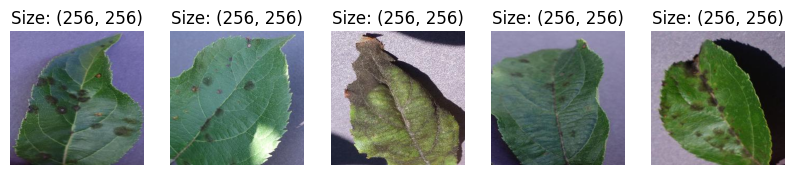

Apple Black Rot:


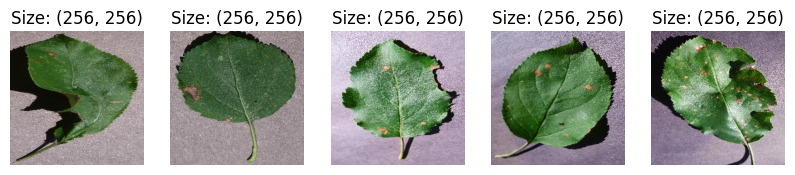

Apple Rust:


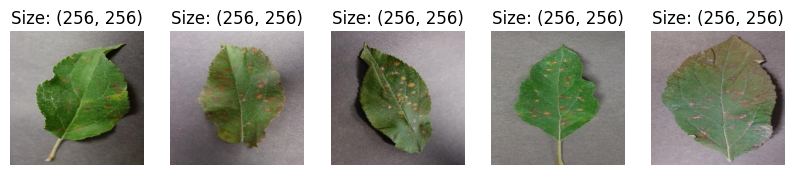

Apple Healthy:


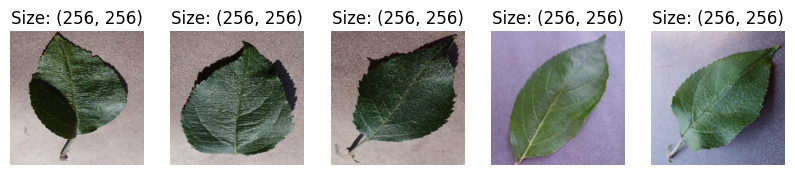

In [11]:
train_Apple_scab_directory = os.path.join(train_dataset_location, 'Apple___Apple_scab')
train_Black_rot_directory = os.path.join(train_dataset_location, 'Apple___Black_rot')
train_Apple_rust_directory = os.path.join(train_dataset_location, 'Apple___Cedar_apple_rust')
train_Apple_healthy_directory = os.path.join(train_dataset_location, 'Apple___healthy')


print("Apple Scab:")
visualize_images(train_Apple_scab_directory)

print("Apple Black Rot:")
visualize_images(train_Black_rot_directory)

print("Apple Rust:")
visualize_images(train_Apple_rust_directory)

print("Apple Healthy:")
visualize_images(train_Apple_healthy_directory )

In [12]:
target_size = (224,224)

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    rescale=1./255
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dataset_location,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    valid_dataset_location,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dataset_location,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

Found 1940 images belonging to 4 classes.
Found 243 images belonging to 4 classes.
Found 243 images belonging to 4 classes.


In [15]:
train_generator.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3}

In [16]:
val_generator.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3}

In [17]:
test_generator.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3}

In [19]:
model = Sequential()
get_mobilenet_v2_pretrained_model = hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/075-224-classification/versions/2", trainable=False)
model_mobilenet_v2 = hub.KerasLayer(get_mobilenet_v2_pretrained_model, input_shape=(224,224,3)) 
model.add(model_mobilenet_v2)

model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(4, activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              2664345   
                                                                 
 batch_normalization (BatchN  (None, 1001)             4004      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               128256    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)              

In [21]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=2e-5), metrics=['accuracy'])

In [42]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(train_generator, validation_data=val_generator, epochs=40,callbacks=[early_stopping])

Epoch 1/40
61/61 [==============================] - 39s 474ms/step - loss: 1.8732 - accuracy: 0.2706 - val_loss: 1.4605 - val_accuracy: 0.3004
Epoch 2/40
61/61 [==============================] - 24s 391ms/step - loss: 1.6720 - accuracy: 0.3222 - val_loss: 1.3156 - val_accuracy: 0.3909
Epoch 3/40
61/61 [==============================] - 25s 401ms/step - loss: 1.4739 - accuracy: 0.3990 - val_loss: 1.1991 - val_accuracy: 0.4815
Epoch 4/40
61/61 [==============================] - 23s 383ms/step - loss: 1.2859 - accuracy: 0.4680 - val_loss: 1.1013 - val_accuracy: 0.5514
Epoch 5/40
61/61 [==============================] - 23s 384ms/step - loss: 1.1921 - accuracy: 0.5046 - val_loss: 1.0141 - val_accuracy: 0.6091
Epoch 6/40
61/61 [==============================] - 24s 392ms/step - loss: 1.0752 - accuracy: 0.5557 - val_loss: 0.9438 - val_accuracy: 0.6379
Epoch 7/40
61/61 [==============================] - 25s 401ms/step - loss: 1.0355 - accuracy: 0.5907 - val_loss: 0.8731 - val_accuracy: 0.6955

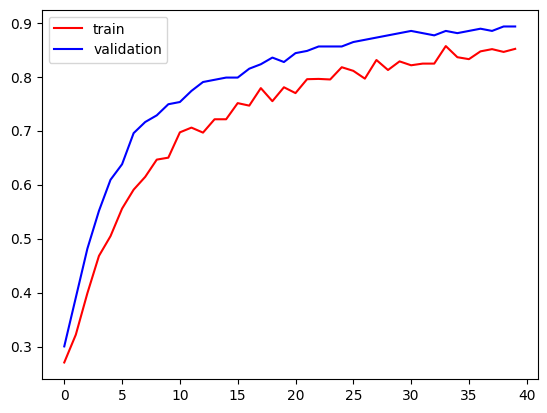

In [43]:
plt.plot(history.history['accuracy'],color = 'red',label='train')
plt.plot(history.history['val_accuracy'],color = 'blue',label = 'validation')
plt.legend()
plt.show()

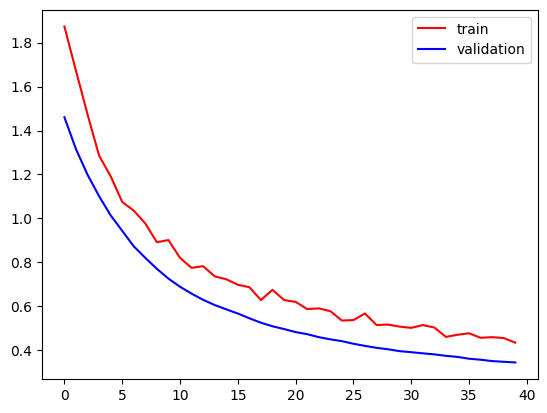

In [44]:
plt.plot(history.history['loss'],color = 'red',label='train')
plt.plot(history.history['val_loss'],color = 'blue',label = 'validation')
plt.legend()
plt.show()

In [45]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

8/8 [==============================] - 1s 108ms/step - loss: 0.4024 - accuracy: 0.8519
Test Loss: 0.40244603157043457
Test Accuracy: 0.8518518805503845


In [46]:
img_path = r'C:\Users\abhij\Desktop\Image Classification\appleleafdataset\test\Apple___Black_rot\acb4845c-bee1-478c-b11c-ade0ae397c51___JR_FrgE.S 8818.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [47]:
predictions = model.predict(img_array)
class_names = ['Apple___Apple_scab', 'Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy']
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
print(predicted_class)

1/1 [==============================] - 2s 2s/step
Apple___Black_rot
